In [1]:
import numpy as np
import pandas as pd
#import re
import seaborn as sns
#import matplotlib.pyplot as plt
from datetime import datetime

%matplotlib inline

pip install voila #failed

https://realpython.com/python-data-cleaning-numpy-pandas/

>>attempt 2: reclaiming the time column

todo: use fuzzy logic to assign columns https://www.datacamp.com/community/tutorials/fuzzy-string-python

In [2]:
RawDairy = pd.read_excel('raw-dairy-data.xlsx', sheet_name=1)
#RawDairy.sheet_names
#cutting out 'HPLC, %db' until i know what it is

#TODO STRIP COLUMN NAMES FIRST

RawDairy = RawDairy[[ 'Analysis Date/Time', 'Analysis ID', 
       'IgG, As-Is %', 'Moisture, %', 'IgG, Dry Base %', 'Dairy Name ',
       'Cow Herd ', 'Region  ']]

RawDairy.columns

Index(['Analysis Date/Time', 'Analysis ID', 'IgG, As-Is %', 'Moisture, %',
       'IgG, Dry Base %', 'Dairy Name ', 'Cow Herd ', 'Region  '],
      dtype='object')

In [3]:
print("there are approximately", len(RawDairy['Dairy Name '].unique()), "unique dairies in the database")
#mispellings may skew this number

there are approximately 363 unique dairies in the database


In [4]:
RawDairy.columns = [ 'Analysis Date/Time', 'Analysis ID', 
       'IgG, As-Is %', 'Moisture, %', 'IgG, Dry Base %', 'Dairy Name',
       'Cow Herd', 'Region'] #trimmed columns

Some "multiple samples" are actually just tests performed on the same buckets to calculate machine accuracy
need to create a function that identifies very similar entries at the same date/values, and mark them as duplicates

In [5]:
RawDairy['Analysis Date/Time'].describe()

count                  584
unique                 584
top       07/19/2021 16:38
freq                     1
Name: Analysis Date/Time, dtype: object

In [6]:
RawDairy.shape

(586, 8)

In [7]:
RawDairy['Analysis Date/Time'].iloc[5]
#is a mix of inconsistent strings, and date times

datetime.datetime(2021, 5, 10, 11, 58)

In [8]:
test = pd.to_datetime(RawDairy['Analysis Date/Time'], errors = "coerce")
test.describe()

test.isnull().values.sum()

C:\Users\hanst\Anaconda3\envs\Milkoscan2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  


2

test.iloc[1].total_seconds()

In [9]:
RawDairy.isnull().sum().sum()

28

In [10]:
RawDairy['Analysis Date/Time'] = test
RawDairy.dtypes

Analysis Date/Time    datetime64[ns]
Analysis ID                   object
IgG, As-Is %                  object
Moisture, %                   object
IgG, Dry Base %               object
Dairy Name                    object
Cow Herd                     float64
Region                        object
dtype: object

In [11]:
#probably sort the list by date, then check the prior entries for identical names/similar values. 

In [12]:
RawDairy.head()

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
0,2021-07-19 16:38:00,AZ41768704,0.17,88.44,1.47,West Side Jersey's or Neil Souza,1100.0,Ripon
1,2021-07-19 14:15:00,AZ30038704,0.25,84.97,1.66,BARLASS JERSEYS LLC,400.0,WI
2,2021-05-07 12:11:00,AZ42790983,0.36,81.78,1.98,DEN-K HOLSTEINS,350.0,Ripon
3,2021-05-06 13:25:00,AZ31718883,0.45,77.62,2.01,Norman W Zimmerman Jr.,400.0,NY
4,2021-05-06 13:52:00,AZ50628883,0.61,70.33,2.06,Jason Hoover,300.0,NY


In [13]:
print(RawDairy.dtypes)


RawDairy = RawDairy.replace('#N/A',np.nan)
RawDairy = RawDairy.replace('Outlier',np.nan)

RawDairy = RawDairy.dropna()
print(RawDairy.shape)


RawDairy.isnull().sum().sum() #no nulls


Analysis Date/Time    datetime64[ns]
Analysis ID                   object
IgG, As-Is %                  object
Moisture, %                   object
IgG, Dry Base %               object
Dairy Name                    object
Cow Herd                     float64
Region                        object
dtype: object
(568, 8)


0

In [14]:
RawDairy.shape

(568, 8)

to numeric, or stripped string:

In [15]:
for column in RawDairy.columns:
    if column in ['IgG, As-Is %', 'Moisture, %', 'IgG, Dry Base %', \
              'Cow Herd',   \
                  'Total-IGG']:
        print(column)
        #roadDeaths[column] = roadDeaths[column].astype(float)
        RawDairy[column] = pd.to_numeric(RawDairy[column], errors='coerce', downcast='float')
    elif column == "Analysis Date/Time":
        pass
        #already coerced into timestamp
    else:
        RawDairy[column] = RawDairy[column].astype(str)
        #pd.Series(['a', 'b', 'c'], dtype="string")
        RawDairy[column] = RawDairy[column].str.strip()
RawDairy.dtypes

IgG, As-Is %
Moisture, %
IgG, Dry Base %
Cow Herd


Analysis Date/Time    datetime64[ns]
Analysis ID                   object
IgG, As-Is %                 float32
Moisture, %                  float32
IgG, Dry Base %              float32
Dairy Name                    object
Cow Herd                     float32
Region                        object
dtype: object

In [16]:
df = RawDairy.loc[RawDairy["Dairy Name"] == "Sunview "]#.describe()
df #sunview is now trimmed

if len(df) > 0:
    raise ValueError('trim failed?')

In [17]:
RawDairy.isnull().sum().sum()


2

does not seem worth rescuing 2 null values

In [18]:
RawDairy = RawDairy.dropna()


>removing duplicates by time

In [19]:
RawDairy = RawDairy.sort_values(by=['Analysis Date/Time'])
RawDairy.head()

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
291,2021-04-01 11:28:00,AZ43101083,2.24,80.089996,11.25,DELBERT DENURE,100.0,WI
265,2021-04-01 11:30:00,AZ58101083,2.19,79.260002,10.56,DELBERT DENURE,100.0,WI
344,2021-04-01 11:32:00,AZ34201083,2.29,82.029999,12.74,Five Star Dairy LLC,1200.0,OH
270,2021-04-01 11:33:00,AZ31301083,2.26,78.900002,10.71,Five Star Dairy LLC,1200.0,OH
184,2021-04-01 11:40:00,AZ56401083,1.62,81.120003,8.58,GRIESBACH FAMILY FARM LLC,300.0,WI


calculate the variance of some relevant measurement var, like moisture, set a threshold for a very small difference, if the time of a row is very similar, and a moisture is similar, then discard row.

In [20]:
RawDairy["Analysis Date/Time"].describe()

C:\Users\hanst\Anaconda3\envs\Milkoscan2\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  """Entry point for launching an IPython kernel.


count                     566
unique                    566
top       2021-04-01 11:28:00
freq                        1
first     2021-04-01 11:28:00
last      2021-07-19 16:47:00
Name: Analysis Date/Time, dtype: object

we can find a similarity metric like dedupe to make this better later, for now just do a quick hack
https://stackoverflow.com/questions/39490190/pandas-fuzzy-detect-duplicates

In [21]:
#RawDairy["Moisture, %"].describe()
RawDairy["IgG, As-Is %"].describe()  
#igg as is has a lot more variance/mean that moisture, 
#it is better to use that as a similarity metric instead of moisture

count    566.000000
mean       2.474117
std        1.327105
min        0.170000
25%        1.462500
50%        2.235000
75%        3.257500
max        6.390000
Name: IgG, As-Is %, dtype: float64

In [22]:
list1 = [[1,2],[3,4]]

for x, y in list1:
    print(x)

1
3


for row, index in zip(RawDairy.itertuples(), range(len(RawDairy))) :
    date = row[1]
    name = row[6]
    iggAsIs = row[3]
    #print(row) #Pandas(Index=291, _1=Timestamp('2021-04-01 11:28:00'), _2='AZ43101083', _3=2.240000009536743, _4=80.08999633789062, _5=11.25, _6='DELBERT DENURE', _7=100.0, Region='WI')
    if name in popList:
        for altName, altIGG in popList:
            print(altName, altIGG)
            if abs(iggAsIs-altIGG) < .55 and name == altName:
                duplicates.append(index)
    else:
        popList.append([name, iggAsIs]) 
    if len(popList) > capacity:
        popList = popList[1:]

# delete duplicate entries (very similar time value, and other values)

In [23]:
RawDairy = RawDairy.sort_values(by=['Analysis Date/Time'])
capacity = 5
popList = [] #[[name, date], [name, date]] #pop out an entry after it has exceeded a timelimit
duplicates = [] #[[412, 413],[442,443] ....]

for row, index in zip(RawDairy.itertuples(), range(len(RawDairy))) :
    date = row[1]
    name = row[6]
    iggAsIs = row[3]
    #print(row) #Pandas(Index=291, _1=Timestamp('2021-04-01 11:28:00'), _2='AZ43101083', _3=2.240000009536743, _4=80.08999633789062, _5=11.25, _6='DELBERT DENURE', _7=100.0, Region='WI')
    for recent in popList:
        if name == recent[0]: 
            if abs((recent[1] - date).total_seconds()) < 60*10: #10 minute difference
                duplicates.append(index)
                break
    else:
        popList.append([name, date]) 
    if len(popList) > capacity:
        popList = popList[1:]
    
    
    
    #print(row)
    #break
    
#date.total_seconds()
#total_seconds(date)

print(len(duplicates))
print(duplicates[:20])
RawDairy.head(20)

118
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]


,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
291,2021-04-01 11:28:00,AZ43101083,2.24,80.089996,11.25,DELBERT DENURE,100.0,WI
265,2021-04-01 11:30:00,AZ58101083,2.19,79.260002,10.56,DELBERT DENURE,100.0,WI
344,2021-04-01 11:32:00,AZ34201083,2.29,82.029999,12.74,Five Star Dairy LLC,1200.0,OH
270,2021-04-01 11:33:00,AZ31301083,2.26,78.900002,10.71,Five Star Dairy LLC,1200.0,OH
184,2021-04-01 11:40:00,AZ56401083,1.62,81.120003,8.58,GRIESBACH FAMILY FARM LLC,300.0,WI
131,2021-04-01 11:41:00,AZ42501083,1.48,80.519997,7.60,GRIESBACH FAMILY FARM LLC,300.0,WI
488,2021-04-01 11:43:00,AZ48501083,3.98,77.769997,17.90,HARLAN JORDAN,250.0,WI
520,2021-04-01 11:45:00,AZ43601083,4.08,78.790001,19.24,HARLAN JORDAN,250.0,WI
345,2021-04-01 11:47:00,AZ30701083,3.31,74.059998,12.76,HILLSIDE DAIRY,350.0,WI
340,2021-04-01 11:49:00,AZ37701083,3.31,73.790001,12.63,HILLSIDE DAIRY,350.0,WI


In [24]:
RawDairyDeDupe = RawDairy.drop(RawDairy.index[duplicates])
RawDairyDeDupe.head(15)


,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
291,2021-04-01 11:28:00,AZ43101083,2.24,80.089996,11.25,DELBERT DENURE,100.0,WI
344,2021-04-01 11:32:00,AZ34201083,2.29,82.029999,12.74,Five Star Dairy LLC,1200.0,OH
184,2021-04-01 11:40:00,AZ56401083,1.62,81.120003,8.58,GRIESBACH FAMILY FARM LLC,300.0,WI
488,2021-04-01 11:43:00,AZ48501083,3.98,77.769997,17.90,HARLAN JORDAN,250.0,WI
345,2021-04-01 11:47:00,AZ30701083,3.31,74.059998,12.76,HILLSIDE DAIRY,350.0,WI
208,2021-04-01 11:50:00,AZ52801083,2.21,75.459999,9.01,JOHN KNUDTSON,115.0,WI
383,2021-04-01 11:54:00,AZ42901083,2.28,83.599998,13.90,KLIEBENSTEIN DAIRY and/or Nate Kliebenstein,200.0,WI
398,2021-04-01 11:58:00,AZ39901083,2.88,79.800003,14.26,NELSON ZIMMERMAN,150.0,OH
359,2021-04-01 12:02:00,AZ49011083,3.20,75.860001,13.26,OLEARY SHAMROCK ACRES LLC,150.0,WI
181,2021-04-01 12:05:00,AZ41211083,1.85,78.430000,8.58,OSENTOSKI DAIRY,200.0,OH


In [25]:
RawDairyDeDupe.shape

(448, 8)

In [26]:
RawDairy = RawDairyDeDupe

6) Create a scatter matrix of all numerical fields. Do any fields appear to be correlated?



In [27]:
from pandas.plotting import scatter_matrix

import matplotlib.pyplot as plt

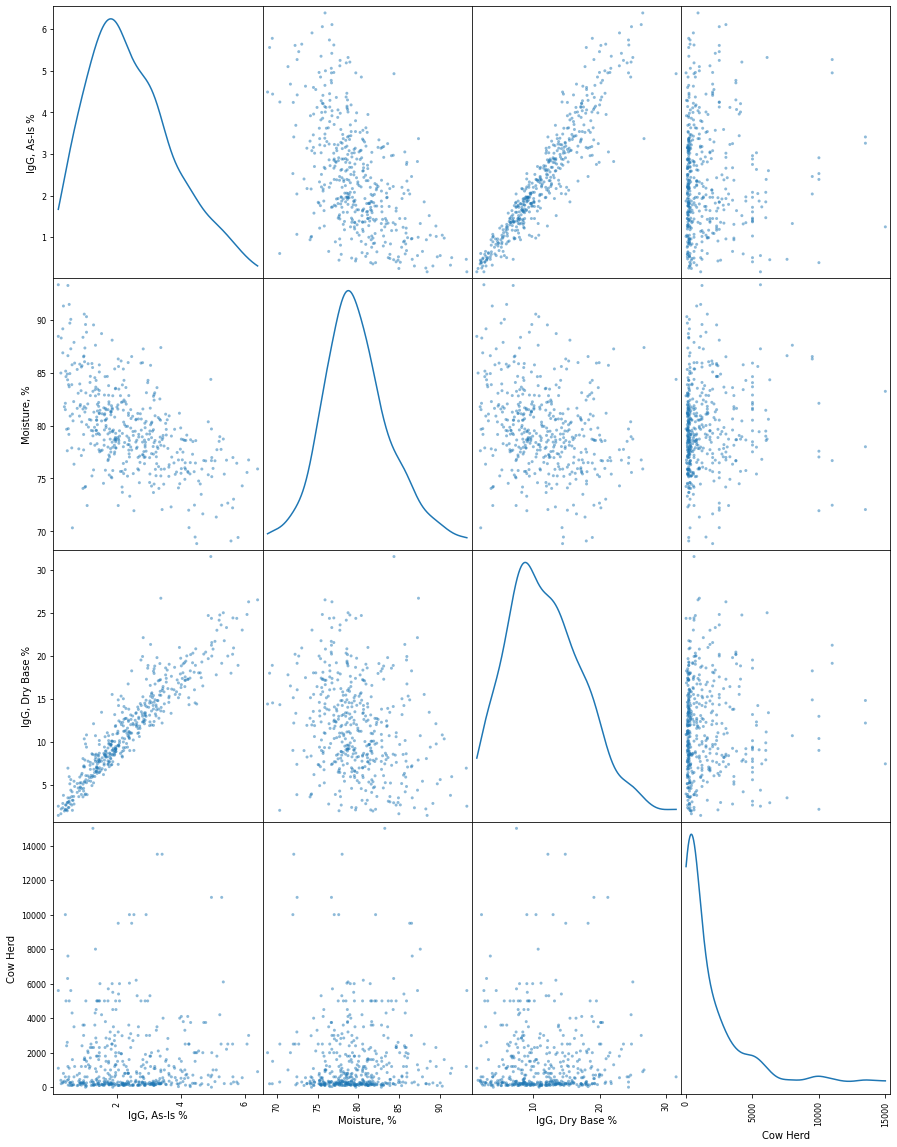

In [28]:



#plt.figure(figsize= (18,9))
RawDairy2 = RawDairy.copy()

#RawDairy2.columns = ['C/A', 'Pop for 2016', 'GNIPC 2016', 'Income Level', \
#                '# traffic deaths', 'Point estimate',   \
#                  'death rate/100000 ', 'Drivers/Passengers 4', \
 #                 'Drivers/Passengers 2/3', 'Cyclists', 'Pedestrians', 'Other' ]


#RawDairy2= RawDairy2.drop(columns = "Total-IGG")
    
#RawDairy2 = RawDairy2.sort_values(by=['Moisture, %']) doesnt seem to do anything

    
scatter_matrix(RawDairy2, diagonal='kde',figsize=(15, 20))

#plt.show()

print("")



<AxesSubplot:xlabel='Moisture, %', ylabel='IgG, Dry Base %'>

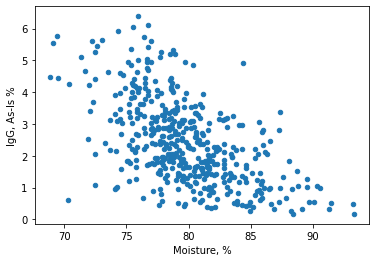

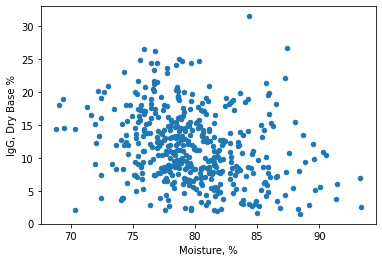

In [29]:
RawDairy2.plot.scatter(x = "Moisture, %", y = "IgG, As-Is %")
RawDairy2.plot.scatter(x = "Moisture, %", y = "IgG, Dry Base %")

Moisture seems to have no ability to predict IGG in dried product. 



In [30]:
pd.options.display.float_format = '{:,.3f}'.format
RawDairy.describe()


,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Cow Herd
count,448.000,448.000,448.000,448.000
mean,2.424,79.729,11.659,"1,564.357"
std,1.327,4.078,5.510,"2,202.904"
min,0.170,68.840,1.470,0.000
25%,1.427,77.050,7.707,200.000
50%,2.205,79.235,11.055,600.000
75%,3.223,81.900,15.322,"2,025.000"
max,6.390,93.320,31.540,"15,000.000"


mapping = {0:'y', 1:'n', 2:'y', 3:'n', 4:'y'}
﻿df.groupby(mapping).mean()


RegionGroup = RawDairy.groupby('Region')
for name, group in RegionGroup:
        print(name)
        #print(group,"\n")

for group in RegionGroup:
    print(group)
    break

RegionGroup = RawDairy.groupby('Region')   #.agg(['mean','std','count'])

#for name, group in RegionGroup:
        #print(name)
        #print(group,"\n")

for group in RegionGroup:
    print(group)
    break
#print(RegionGroup.agg(['mean','std','count']))



#weightedAvg(RawDairy, 'IgG, Dry Base %', 'Cow Herd')

In [31]:
from statsmodels.stats.weightstats import DescrStatsW
import math


In [32]:
RawDairy["Region"].replace("ID ", "ID", inplace = True)

In [33]:
minInclusionCount = 2

         Mean    SD  MeanSE  count
Region                            
WI     10.180 4.009   0.604     44
OH     11.376 4.489   0.515     76
Ripon  10.387 6.378   1.021     39
Tulare 13.335 5.689   0.603     89
ID     10.803 5.495   0.626     77
NM     17.705 1.195   0.845      2
NY     11.208 5.124   0.491    109
AZ     11.009 3.533   1.065     11


<AxesSubplot:title={'center':'Dry Base % Weighted Mean & Mean Standard Error'}, ylabel='Region'>

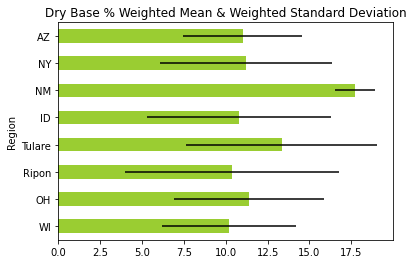

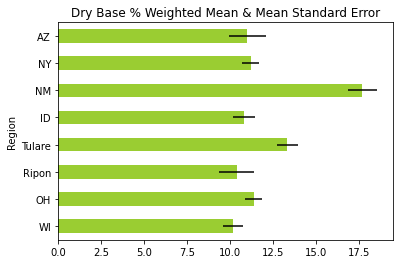

In [34]:
#RegionGroup.get_group("AZ").describe()

#@interact

statList= []
for region in RawDairy["Region"].unique():
    regionDF = RawDairy.loc[RawDairy["Region"] == region]#.describe()
    count = regionDF.shape[0]
    
    regionNumpy = regionDF.to_numpy()
    dry = regionNumpy[:,4]
    herdSize = regionNumpy[:,6]  #[200,400,500....]
    weighted_stats = DescrStatsW(dry, weights=herdSize, ddof=0)
    if count >= minInclusionCount:  #calculating std from single samples causes an error, and doesnt make sense
        weighted_stats.mean
        weighted_stats.std
        weighted_stats.std_mean
        #print(region, "mean", weighted_stats.mean, "SD", weighted_stats.std, "MeanSD", weighted_stats.std_mean, count)
        statList.append([region, weighted_stats.mean, weighted_stats.std,( weighted_stats.std /math.sqrt(count)), count])
          
          #weightedAvg(temp, 'IgG, Dry Base %', 'Cow Herd'), "count:", length)
    
    #break

    
    
df = pd.DataFrame(statList, columns =['Region', 'Mean', "SD", "MeanSE", "count"])
df = df.set_index('Region')
print(df)
df.plot(kind = "barh", y = "Mean", legend = False, xerr = "SD", title = "Dry Base % Weighted Mean & Weighted Standard Deviation", color='yellowgreen')
df.plot(kind = "barh", y = "Mean", legend = False, xerr = "MeanSE", title = "Dry Base % Weighted Mean & Mean Standard Error", color='yellowgreen')


https://stats.stackexchange.com/questions/25895/computing-standard-error-in-weighted-mean-estimation
there is no widely accepted definition of standard error of the weighted mean

NM has a low sample size but a low standard error mean, because all samples are from the same dairy and have a low Standard deviation

In [35]:
RawDairy.loc[RawDairy["Region"] == "NM"]

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
459,2021-04-13 14:59:00,AZ50456283,4.680,71.650,16.510,Grand Canyon Dairy,"2,000.000",NM
512,2021-05-10 12:41:00,AZ55468983,4.450,76.460,18.900,Grand Canyon Dairy,"2,000.000",NM


Regions/farms with a sample size of one cannot be used to calculate standard deviation metrics

In [36]:

regionDF = RawDairy.loc[RawDairy["Region"] == "IN"]
regionDF


,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
268,2021-05-07 16:39:00,AZ47551983,2.370,77.680,10.620,JERANGLE DAIRY LLC,225.000,IN


In [37]:
#RegionGroup.get_group("AZ").describe()


statList= []
for region in RawDairy["Dairy Name"].unique():
    regionDF = RawDairy.loc[RawDairy["Dairy Name"] == region]#.describe()
    count = regionDF.shape[0]
    
    
    
    regionNumpy = regionDF.to_numpy()
    dry = regionNumpy[:,4]
    wet = regionNumpy[:,2]
    herdSize = regionNumpy[:,6]  #[200,400,500....]
    
    if count >= minInclusionCount:  #calculating std from single samples causes an error, and doesnt make sense
            weighted_stats = DescrStatsW(dry,  ddof=0) #weights=herdSize,
        
            wet_stats = DescrStatsW(wet,  ddof=0)
            #weighted_stats.mean
            #weighted_stats.std
            #weighted_stats.std_mean
            #print(region, "mean", weighted_stats.mean, "SD", weighted_stats.std, "MeanSD", weighted_stats.std_mean, count)
            statList.append([region, wet_stats.mean, weighted_stats.mean, weighted_stats.std,( weighted_stats.std /math.sqrt(count)), count])
          
          #weightedAvg(temp, 'IgG, Dry Base %', 'Cow Herd'), "count:", length)
    
    #break

    
    
df = pd.DataFrame(statList, columns =['Dairy Name', 'WetMean','DryMean', "SD", "MeanSE", "count"])
df = df.set_index('Dairy Name')
#print(df)
#df.plot(kind = "barh", y = "Mean", legend = False, xerr = "SD", title = "Dry Base % Mean/Standard Deviation", color='green', figsize=(10, 20))
#df.plot(kind = "barh", y = "Mean", legend = False, xerr = "MeanSE", title = "Dry Base % Mean & Mean Standard Error", color='green')

In [38]:
#df['count'] > 3


test = df[df['count'] >= minInclusionCount]
#for item in test.index:
#    print (item)
#RawDairy['Cow Herd']  #in test.index
#RawDairy.dtypes

resetTest = test.reset_index()
#print("VOEGELI FARMS INC" in resetTest["Dairy Name"].values)
(resetTest["Dairy Name"] == "VOEGELI FARMS INC").any()

#temp = RawDairy[['Dairy Name','Cow Herd']]
#for item in test.index:
 #   temp= temp[temp['Dairy Name'] ==
 #   tobacco_current = tobacco[tobacco['YEAR'] != '2012']

compressed = RawDairy[["Dairy Name", "Cow Herd"]].groupby("Dairy Name").agg("median")
#for row in compressed.itertuples() :
#    name = row[0]
#    herdSize = row[1]
#    if name in resetTest["Dairy Name"].values:
        #print(name, "herd size:", herdSize )
        

    

In [39]:
combined = compressed.merge(df, left_on='Dairy Name', right_on='Dairy Name')
combined.head()

,Cow Herd,WetMean,DryMean,SD,MeanSE,count
Dairy Name,,,,,,
4 Bros,"13,500.000",3.335,13.510,1.310,0.926,2
AJB Ranch,"5,000.000",2.855,19.045,0.475,0.336,2
ANDREW HOULBERG,120.000,0.910,5.375,0.715,0.506,2
Acme Dairy,"5,300.000",2.830,12.130,0.200,0.141,2
BAUDHUIN FARMS LLC,200.000,5.670,18.445,0.455,0.322,2


len(combinedSorted)//2

In [40]:
#combinedSorted

combinedSorted["count"].sum()/449 #40
#40% of data is represented in graph

combinedSortedBackup = combinedSorted


In [41]:
#combinedSorted = combinedSorted2

Min Inclusion: 2


C:\Users\hanst\Anaconda3\envs\Milkoscan2\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


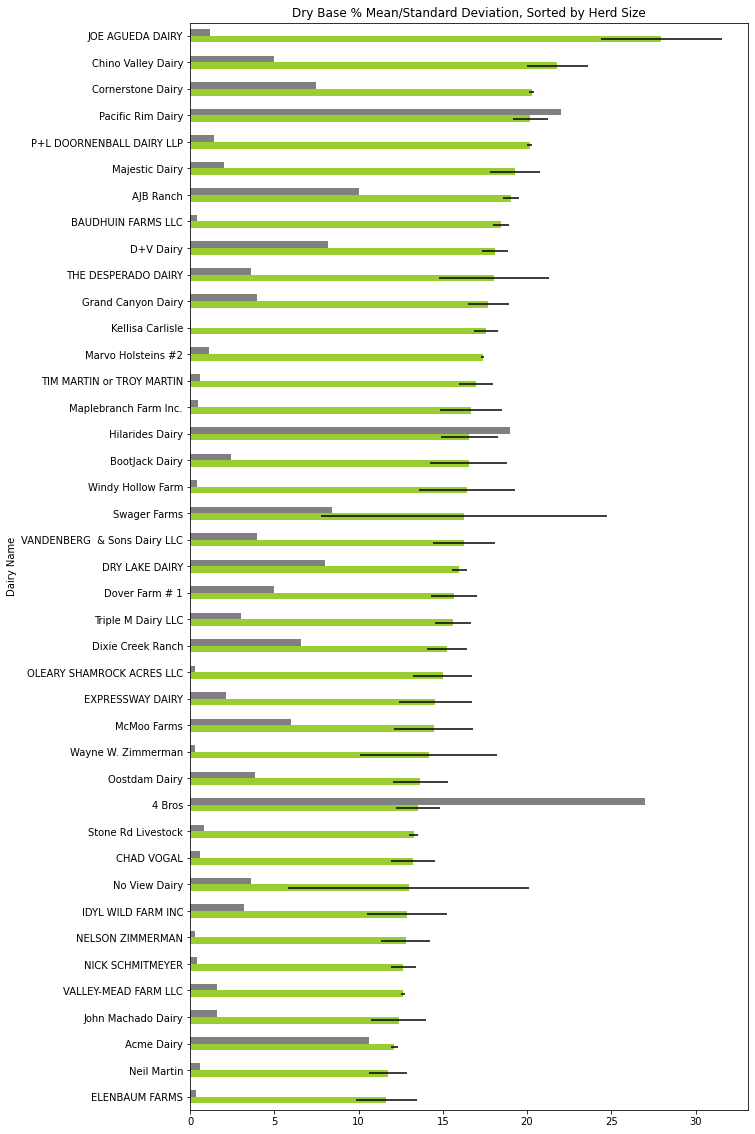

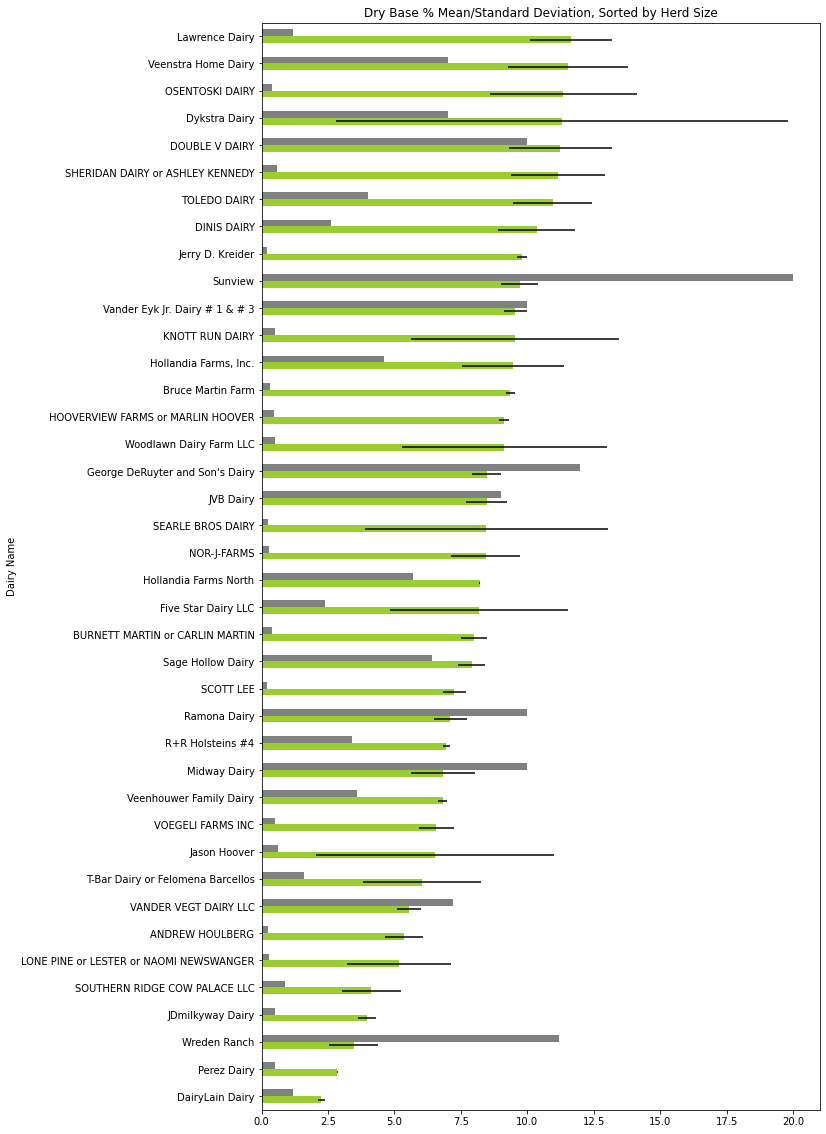

In [42]:
#interact

print("Min Inclusion:", minInclusionCount)
#print(combinedSorted.tail(10))
#combinedSorted["Cow Herd"].plot(use_index = False, title = "Herd size Distribution") #label = "Dairies sorted by herd Size", ylabel = "dairy herd size"


#combinedSorted.plot(kind = "barh", y = "Mean", legend = False, xerr = "SD",  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color='green', figsize=(10, 20))

#combinedSorted.plot(kind = "barh", y = ["Mean", "Cow Herd"], legend = False, xerr = [combinedSorted["SD"], \
#[0] * len(combinedSorted)],  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color=['green', "grey"], \
#                    figsize=(10, 20))


#combinedSorted = combinedSorted["SD"][:len(combinedSorted)//2]

#secondHalf = combinedSorted[len(combinedSorted)//2:]


def scoreChart(combined, minInclusionCount = 2):
    combinedSorted = combined.sort_values(by=['DryMean'])
    combinedSortedBackup = combinedSorted
    
    combinedSorted = combinedSorted.iloc[len(combinedSorted)//2:]
    combinedSorted["Cow Herd"] = combinedSorted["Cow Herd"]/500
    combinedSorted.plot(kind = "barh", y = ["DryMean", "Cow Herd"], legend = False, xerr = [combinedSorted["SD"], \
    [0] * len(combinedSorted)],  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color=['yellowgreen', "grey"], \
                    figsize=(10, 20))
    combinedSorted = combinedSortedBackup
    combinedSorted["Cow Herd"] = combinedSorted["Cow Herd"]/500
    combinedSorted = combinedSorted.iloc[:len(combinedSorted)//2]
    combinedSorted.plot(kind = "barh", y = ["DryMean", "Cow Herd"], legend = False, xerr = [combinedSorted["SD"], \
    [0] * len(combinedSorted)],  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color=['yellowgreen', "grey"], \
                    figsize=(10, 20))
    combinedSorted = combinedSortedBackup
    combinedSorted["Cow Herd"] = combinedSorted["Cow Herd"]*500

scoreChart(combined, minInclusionCount)


combinedSorted["Cow Herd"] = combinedSorted["Cow Herd"]*500


In [43]:
combined

,Cow Herd,WetMean,DryMean,SD,MeanSE,count
Dairy Name,,,,,,
4 Bros,"13,500.000",3.335,13.510,1.310,0.926,2
AJB Ranch,"5,000.000",2.855,19.045,0.475,0.336,2
ANDREW HOULBERG,120.000,0.910,5.375,0.715,0.506,2
Acme Dairy,"5,300.000",2.830,12.130,0.200,0.141,2
BAUDHUIN FARMS LLC,200.000,5.670,18.445,0.455,0.322,2
...,...,...,...,...,...,...
Veenstra Home Dairy,"3,500.000",2.280,11.520,2.260,1.598,2
Wayne W. Zimmerman,150.000,2.495,14.155,4.065,2.874,2
Windy Hollow Farm,200.000,4.010,16.450,2.840,2.008,2


Divide the farms into n ranges sorted by ?, then print mean values 

In [44]:
#is likely to trim off one or two entries that do not cleanly divide
def sectioningAggData(sortString, df, divisor = 3):
    range1 = int(len(combined)/3)
    print("Sorted by", sortString)
    for i in range(divisor):
        print(combined.sort_values(by=[sortString]).iloc[range1*i:range1*(i+1)].agg("mean"))

sectioningAggData(df = combined, sortString = 'WetMean')


Sorted by WetMean
Cow Herd   1,479.222
WetMean        1.220
DryMean        6.972
SD             1.303
MeanSE         0.896
count          2.074
dtype: float64
Cow Herd   2,581.481
WetMean        2.350
DryMean       11.861
SD             1.941
MeanSE         1.316
count          2.148
dtype: float64
Cow Herd   2,332.963
WetMean        4.076
DryMean       17.316
SD             1.604
MeanSE         1.110
count          2.148
dtype: float64


In [45]:
df = RawDairy.loc[RawDairy["Dairy Name"] == "Swager Farms"]#.describe()
df # is a 31% dry base realistic? or is it an outlier

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
141,2021-05-12 08:02:00,AZ51754093,1.520,80.440,7.770,Swager Farms,"4,200.000",ID
566,2021-05-28 14:01:00,AZ46437493,5.210,78.950,24.750,Swager Farms,"4,200.000",ID


In [46]:
df = RawDairy.loc[RawDairy["Dairy Name"] == "JOE AGUEDA DAIRY"]#.describe()
df # is a 31% dry base realistic? or is it an outlier

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
564,2021-04-13 14:32:00,AZ51746283,5.620,76.980,24.410,JOE AGUEDA DAIRY,600.000,ID
573,2021-05-10 12:27:00,AZ50758983,4.930,84.370,31.540,JOE AGUEDA DAIRY,600.000,ID


In [47]:
df = RawDairy.loc[RawDairy["Dairy Name"] == "Wreden Ranch"]#.describe()
df
#an extremely low dry igg percentage
#also a very low deviation

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
44,2021-04-07 09:29:00,AZ30932183,0.560,87.260,4.400,Wreden Ranch,"5,600.000",Tulare
13,2021-05-10 11:26:00,AZ55628983,0.170,93.320,2.540,Wreden Ranch,"5,600.000",Tulare


In [48]:
df = RawDairy.loc[RawDairy["Dairy Name"] == "Cornerstone Dairy"]#.describe()
df
#an extremely low dry igg percentage
#also a very low deviation

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
542,2021-04-06 11:30:00,AZ57020183,4.770,76.660,20.440,Cornerstone Dairy,"3,750.000",Tulare
540,2021-04-07 09:06:00,AZ30432183,4.710,76.700,20.210,Cornerstone Dairy,"3,750.000",Tulare
537,2021-05-10 11:18:00,AZ57228983,4.300,78.660,20.150,Cornerstone Dairy,"3,750.000",Tulare


In [49]:
df = RawDairy.loc[RawDairy["Dairy Name"] == "DOUBLE V DAIRY"]#.describe()
df
#some farms also seem to have an unrealistically small Standard deviation
#this entry took place a month apart, it may be a bucket from the same tank?

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
218,2021-05-12 07:37:00,AZ34744093,1.720,81.510,9.300,DOUBLE V DAIRY,"5,000.000",ID
357,2021-05-28 13:07:00,AZ40327493,2.880,78.160,13.190,DOUBLE V DAIRY,"5,000.000",ID


In [50]:
df = RawDairy.loc[RawDairy["Dairy Name"] == "Sunview"]#.describe()
df

,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
209,2021-04-12 12:00:00,AZ57053283,2.530,71.950,9.020,Sunview,"10,000.000",ID
258,2021-05-10 12:18:00,AZ33258983,2.390,77.030,10.400,Sunview,"10,000.000",ID


Is it worth graphing the standard error of mean? 

In [51]:
combined["count"].describe()

count   81.000
mean     2.123
std      0.331
min      2.000
25%      2.000
50%      2.000
75%      2.000
max      3.000
Name: count, dtype: float64

There is very little variance, most of the entries are 2s, and a handful are 3s. Currently it will not be a significantly different image 
from the graph above

>>>OUTLIER DETECTION

In [52]:
from scipy import stats
#import numpy as np
RawDairy = RawDairy.dropna()

OnlyNumeric = RawDairy[["IgG, As-Is %", "Moisture, %"]]



z = np.abs(stats.zscore(OnlyNumeric))
#print(z)


threshold = 3
print(np.where(z > 3))



(array([251, 433], dtype=int64), array([1, 1], dtype=int64))


In [53]:
np.where(z > 3)

(array([251, 433], dtype=int64), array([1, 1], dtype=int64))

In [54]:
#checking rawdairy and OnlyNumeric have same sorting
#for x in range(50):
    #print(x)
    #print(OnlyNumeric["Moisture, %"].iloc[x] == (RawDairy["Moisture, %"].iloc[x]))
    #all true
if RawDairy.shape[0] != OnlyNumeric.shape[0]:
    raise ValueError('A very specific bad thing happened.')
    

In [55]:
for x, y in zip(np.where(z > 3)[0], np.where(z > 3)[1]):
    #print(x,y)
    print(x,y, RawDairy.iloc[x])
    break
    
    

251 1 Analysis Date/Time    2021-05-10 11:26:00
Analysis ID                    AZ55628983
IgG, As-Is %                        0.170
Moisture, %                        93.320
IgG, Dry Base %                     2.540
Dairy Name                   Wreden Ranch
Cow Herd                        5,600.000
Region                             Tulare
Name: 13, dtype: object


In [56]:
outliers = RawDairy.iloc[np.where(z > 3)[0]]
outliers


,Analysis Date/Time,Analysis ID,"IgG, As-Is %","Moisture, %","IgG, Dry Base %",Dairy Name,Cow Herd,Region
13,2021-05-10 11:26:00,AZ55628983,0.170,93.320,2.540,Wreden Ranch,"5,600.000",Tulare
103,2021-07-19 16:13:00,AZ51168704,0.470,93.250,6.960,Five Star Dairy LLC,"1,200.000",OH


In [57]:
for x, y in zip(np.where(z > 3)[0], np.where(z > 3)[1]):
    print(OnlyNumeric.iloc[x,y])
    if y == 0:
        print(x, "anomaly is IgG, As-Is %")
    if y == 1:
        print(x, "anomaly is Moisture")
    if y == 2:
        print(x, "anomaly is Cow Herd")

93.32
251 anomaly is Moisture
93.25
433 anomaly is Moisture


In [58]:
#combinedSortedBackup.columns

In [59]:
#combinedSortedBackup.plot.scatter(y = "Cow Herd", x = "Mean", title = "Farm-Mean IgG Dry Base % Against Farm Size")

In [60]:
#where is wreden ranch?
#combinedSortedBackup
#It is there, it is just surprising how quickly herd size drops off. at abut the 6000 mark

#Apply a function to divide the farms, and calculate how the cutoff affects total milk/igg production
-log(x -10)*10+10  (10 is arbitrary shift)

!pip install ipywidgets

>>Legacy/unsorted code

In [61]:
import seaborn as sns
import altair as alt 

titanic = sns.load_dataset("titanic")

alt.Chart(titanic).mark_bar().encode(
    alt.X('class'),
    y='count()'
)

alt.Chart(...)

In [62]:
brush = alt.selection(type='interval')

points = alt.Chart(titanic).mark_point().encode(
    x='age:Q',
    y='fare:Q',
    color=alt.condition(brush, 'class:N', alt.value('lightgray'))
).add_selection(
    brush
)

bars = alt.Chart(titanic).mark_bar().encode(
    y='class:N',
    color='class:N',
    x = 'count(class):Q'
).transform_filter(
    brush
)

points & bars

alt.VConcatChart(...)

import PySimpleGUI as sg

layout = [[sg.Text("Hello from PySimpleGUI")], [sg.Button("OK")]]

# Create the window
window = sg.Window("Demo", layout)

# Create an event loop
while True:
    event, values = window.read()
    # End program if user closes window or
    # presses the OK button
    if event == "OK" or event == sg.WIN_CLOSED:
        break

window.close()

In [63]:
(RawDairy['Analysis Date/Time'].iloc[6] - RawDairy['Analysis Date/Time'].iloc[3]).total_seconds()


660.0

In [64]:
RawDairy.columns


Index(['Analysis Date/Time', 'Analysis ID', 'IgG, As-Is %', 'Moisture, %',
       'IgG, Dry Base %', 'Dairy Name', 'Cow Herd', 'Region'],
      dtype='object')

In [65]:
#pip install plotly

import plotly.express as px


datetime(2010, 1, 1)

(RawDairy['Analysis Date/Time'].iloc[6] - datetime(2021, 1, 1)).total_seconds()



fig = px.scatter(RawDairy,
          x='IgG, Dry Base %',
          y='Cow Herd',
          color='Region',
          ) #size='Analysis Date/Time'
fig.show()

print("Min Inclusion:", minInclusionCount)
print(combinedSorted.tail(10))
#combinedSorted["Cow Herd"].plot(use_index = False, title = "Herd size Distribution") #label = "Dairies sorted by herd Size", ylabel = "dairy herd size"


#combinedSorted.plot(kind = "barh", y = "Mean", legend = False, xerr = "SD",  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color='green', figsize=(10, 20))

#combinedSorted.plot(kind = "barh", y = ["Mean", "Cow Herd"], legend = False, xerr = [combinedSorted["SD"], \
#[0] * len(combinedSorted)],  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color=['green', "grey"], \
#                    figsize=(10, 20))

#@interact
def scoreChart(minInclusionCount = 2):
    halflength = len(combinedSorted)//2

    combinedSorted.iloc[:halflength].plot(kind = "barh", y = ["Mean", "Cow Herd"], legend = False, xerr = [combinedSorted["SD"].iloc[:halflength], \
    [0] * halflength],  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color=['greenyellow', "grey"], \
                    figsize=(10, 20))
    combinedSorted.iloc[halflength:].plot(kind = "barh", y = ["Mean", "Cow Herd"], legend = False, xerr = [combinedSorted["SD"].iloc[halflength:], \
    [0] * (len(combinedSorted)-halflength)],  title = "Dry Base % Mean/Standard Deviation, Sorted by Herd Size",  color=['greenyellow', "grey"], \
                    figsize=(10, 20))

scoreChart()



In [66]:
RawDairy.shape

(448, 8)

In [67]:
time = RawDairy['Analysis Date/Time'].iloc[1]

In [68]:
#time.total_seconds() #'str' object has no attribute 'total_seconds'

In [69]:
test = pd.to_datetime(RawDairy['Analysis Date/Time'], errors = "coerce")
time1 = test.iloc[1]

In [70]:
time1 = RawDairy['Analysis Date/Time'].iloc[15]
time1

Timestamp('2021-04-01 12:35:00')


datetime1 = datetime.strptime(time1, "%Y-%m-%d %H:%M:%S")
datetime1

import time

time.mktime(datetime1.timetuple())

In [71]:
#RawDairy['Analysis Date/Time']

dateframe = RawDairy['Analysis Date/Time'].apply(datetime.strptime(time1, "%Y-%m-%d %H:%M:%S"))
datetime1

from datetime import datetime
import time
list1 = []
for row, index in zip(RawDairy.itertuples(), range(len(RawDairy))) :
    date1 = row[1]
    date2 = RawDairy['Analysis Date/Time'].iloc[index]
    datetime1 = datetime.strptime(date1, "%Y-%m-%d %H:%M:%S")
    seconds = time.mktime(datetime1.timetuple())
    list1.append(seconds)
    
    
test = pd.DataFrame(list1,columns=['Column_Name'])
test
#list1

from datetime import datetime
import time
list1 = []
for row, index in zip(RawDairy.itertuples(), range(len(RawDairy))) :
    date1 = row[1]
    date2 = RawDairy['Analysis Date/Time'].iloc[index]
    #atetime1 = datetime.strptime(date1, "%Y-%m-%d %H:%M:%S")
    try:
        datetime1 = datetime.strptime(date1, "%Y-%m-%d %H:%M:%S")
        seconds = time.mktime(datetime1.timetuple())
        list1.append(seconds)
    except ValueError:
        print("test")
    print("test1")
        
    
    
    
    
test = pd.DataFrame(list1,columns=['Column_Name'])
test
#list1

RawDairy.kde()

array([[<AxesSubplot:title={'center':'IgG, Dry Base %'}>]], dtype=object)

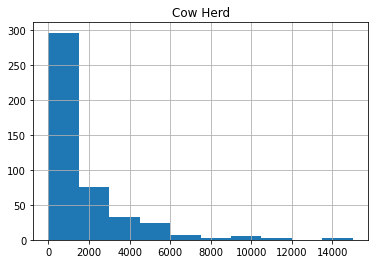

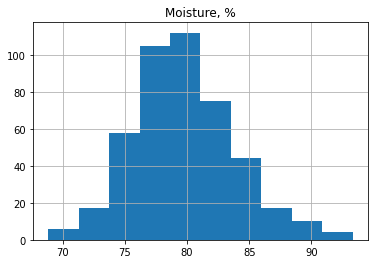

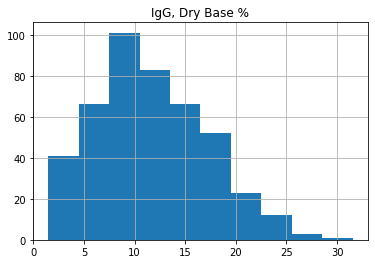

In [72]:
RawDairy.hist(column = "Cow Herd")
RawDairy.hist(column = "Moisture, %")
RawDairy.hist(column = "IgG, Dry Base %")


import numpy as np
RawDairy['Region'].unique()
nulls = RawDairy.index[RawDairy['Region'].isnull()]
for null in nulls:
    print("the null entries:\n\n",RawDairy.iloc[null])

Half-attempt to properly methodize the metric calculation

DataColumn = "Region"
WeightColumn = "Cow Herd"

#takes a Dataframe, and 2 strings
def GroupWeightedStats(DF, DataColumn, WeightColumn):
    for data in DF[DataColumn].unique():
        subDF = DF.loc[RawDairy["Region"] == region]#.describe()
        count = subDF.shape[0]
    
        regionNumpy = subDF.to_numpy()
        dry = regionNumpy[:,4]
        herdSize = regionNumpy[:,6]  #[200,400,500....]
        weightedStats(dry, herdSize)
    
    
        weighted_stats = DescrStatsW(dry, weights=herdSize, ddof=0)
        print(region, weighted_stats.mean, weighted_stats.std, weighted_stats.std_mean, count)

In [73]:
RawDumptank = pd.read_excel('raw-dairy-data.xlsx', sheet_name=2)

cleanedRawDumptank = RawDumptank["IgG, As-Is %"].astype("int", errors = "ignore")   #.agg("mean")

In [74]:
test = pd.to_numeric(RawDumptank["IgG, As-Is %"], errors = "coerce")
test.describe()

test.isnull().values.sum()

8

In [75]:
test = test.replace('#N/A',np.nan)
test = test.replace('Outlier',np.nan)

test = test.dropna()
print(test.shape)

(479,)


In [76]:
test = test.sort_values()

In [77]:
test

397   0.140
120   0.290
237   0.500
121   0.510
351   0.610
       ... 
461   4.870
447   5.210
467   5.670
445   5.820
482   6.060
Name: IgG, As-Is %, Length: 479, dtype: float64

test.plot(kind = "hist")

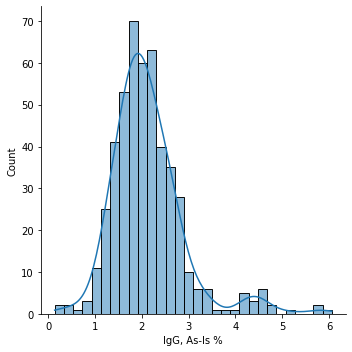

In [78]:


sns.displot(data=test, kde=True)



In [79]:
test.agg("mean")

2.124759916492693

In [80]:
#pip freeze